<a href="https://colab.research.google.com/github/MeiChenc/Bankruptcy-Prediction-Unsupervised/blob/main/Bankruptcy_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_predict
import seaborn as sns
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from scipy.stats import mode # perform the result of prediction on test set
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action="ignore")


In [ ]:
df = pd.read_csv('/content/train (1).csv')
df.head()


,Unnamed: 0,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability,Bankrupt?
0,2490,0.412178,0.474270,0.457733,0.000000,0.000000,0.988045,0.784312,0.796607,0.303526,...,0.002466,0.626786,0.000000,0.838652,0.274813,0.026789,0.565148,1,0.743588,0
1,6721,0.477502,0.537015,0.531774,0.617492,0.617377,0.999009,0.797387,0.809315,0.303436,...,0.000633,0.623705,0.617488,0.840200,0.277850,0.027683,0.567464,1,0.040781,0
2,82,0.480622,0.487080,0.534611,0.617867,0.617867,0.999022,0.797242,0.809177,0.303157,...,0.010964,0.623702,0.617865,0.835834,0.288331,0.026665,0.564475,1,0.017324,0
3,3960,0.547701,0.546064,0.579314,0.608008,0.608008,0.999119,0.797613,0.809432,0.303601,...,0.004277,0.623114,0.608003,0.840497,0.276189,0.026910,0.565666,1,0.074439,0
4,2362,0.496271,0.556258,0.540232,0.598481,0.598481,0.999012,0.797448,0.809350,0.303535,...,0.001606,0.624292,0.598483,0.841437,0.282287,0.026821,0.565295,1,0.022960,0


In [ ]:
df.shape

(5455, 97)

In [ ]:
df.columns

Index(['Unnamed: 0',
       ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operatin

In [ ]:
'Bankrupt?' in df.columns

True

In [ ]:
#Bankruptcy rate
companies = df['Bankrupt?'].value_counts()
num_zero = np.count_nonzero(df['Bankrupt?'] == 0)
bankrupt_rate = num_zero / len(df['Bankrupt?'])
print("Bankruptcy rate: ", bankrupt_rate)
print('Bankruptcy classes:\n ', companies)

Bankruptcy rate:  0.9688359303391384
Bankruptcy classes:
  Bankrupt?
0    5285
1     170
Name: count, dtype: int64


In [ ]:
# Split train data to train and validation
x = df.drop(columns = ['Unnamed: 0', 'Bankrupt?'], axis = 1).dropna() #Features
y = df['Bankrupt?'].dropna() # predict variables
#x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.3, random_state = 42)
x.shape, y.shape

((5455, 95), (5455,))

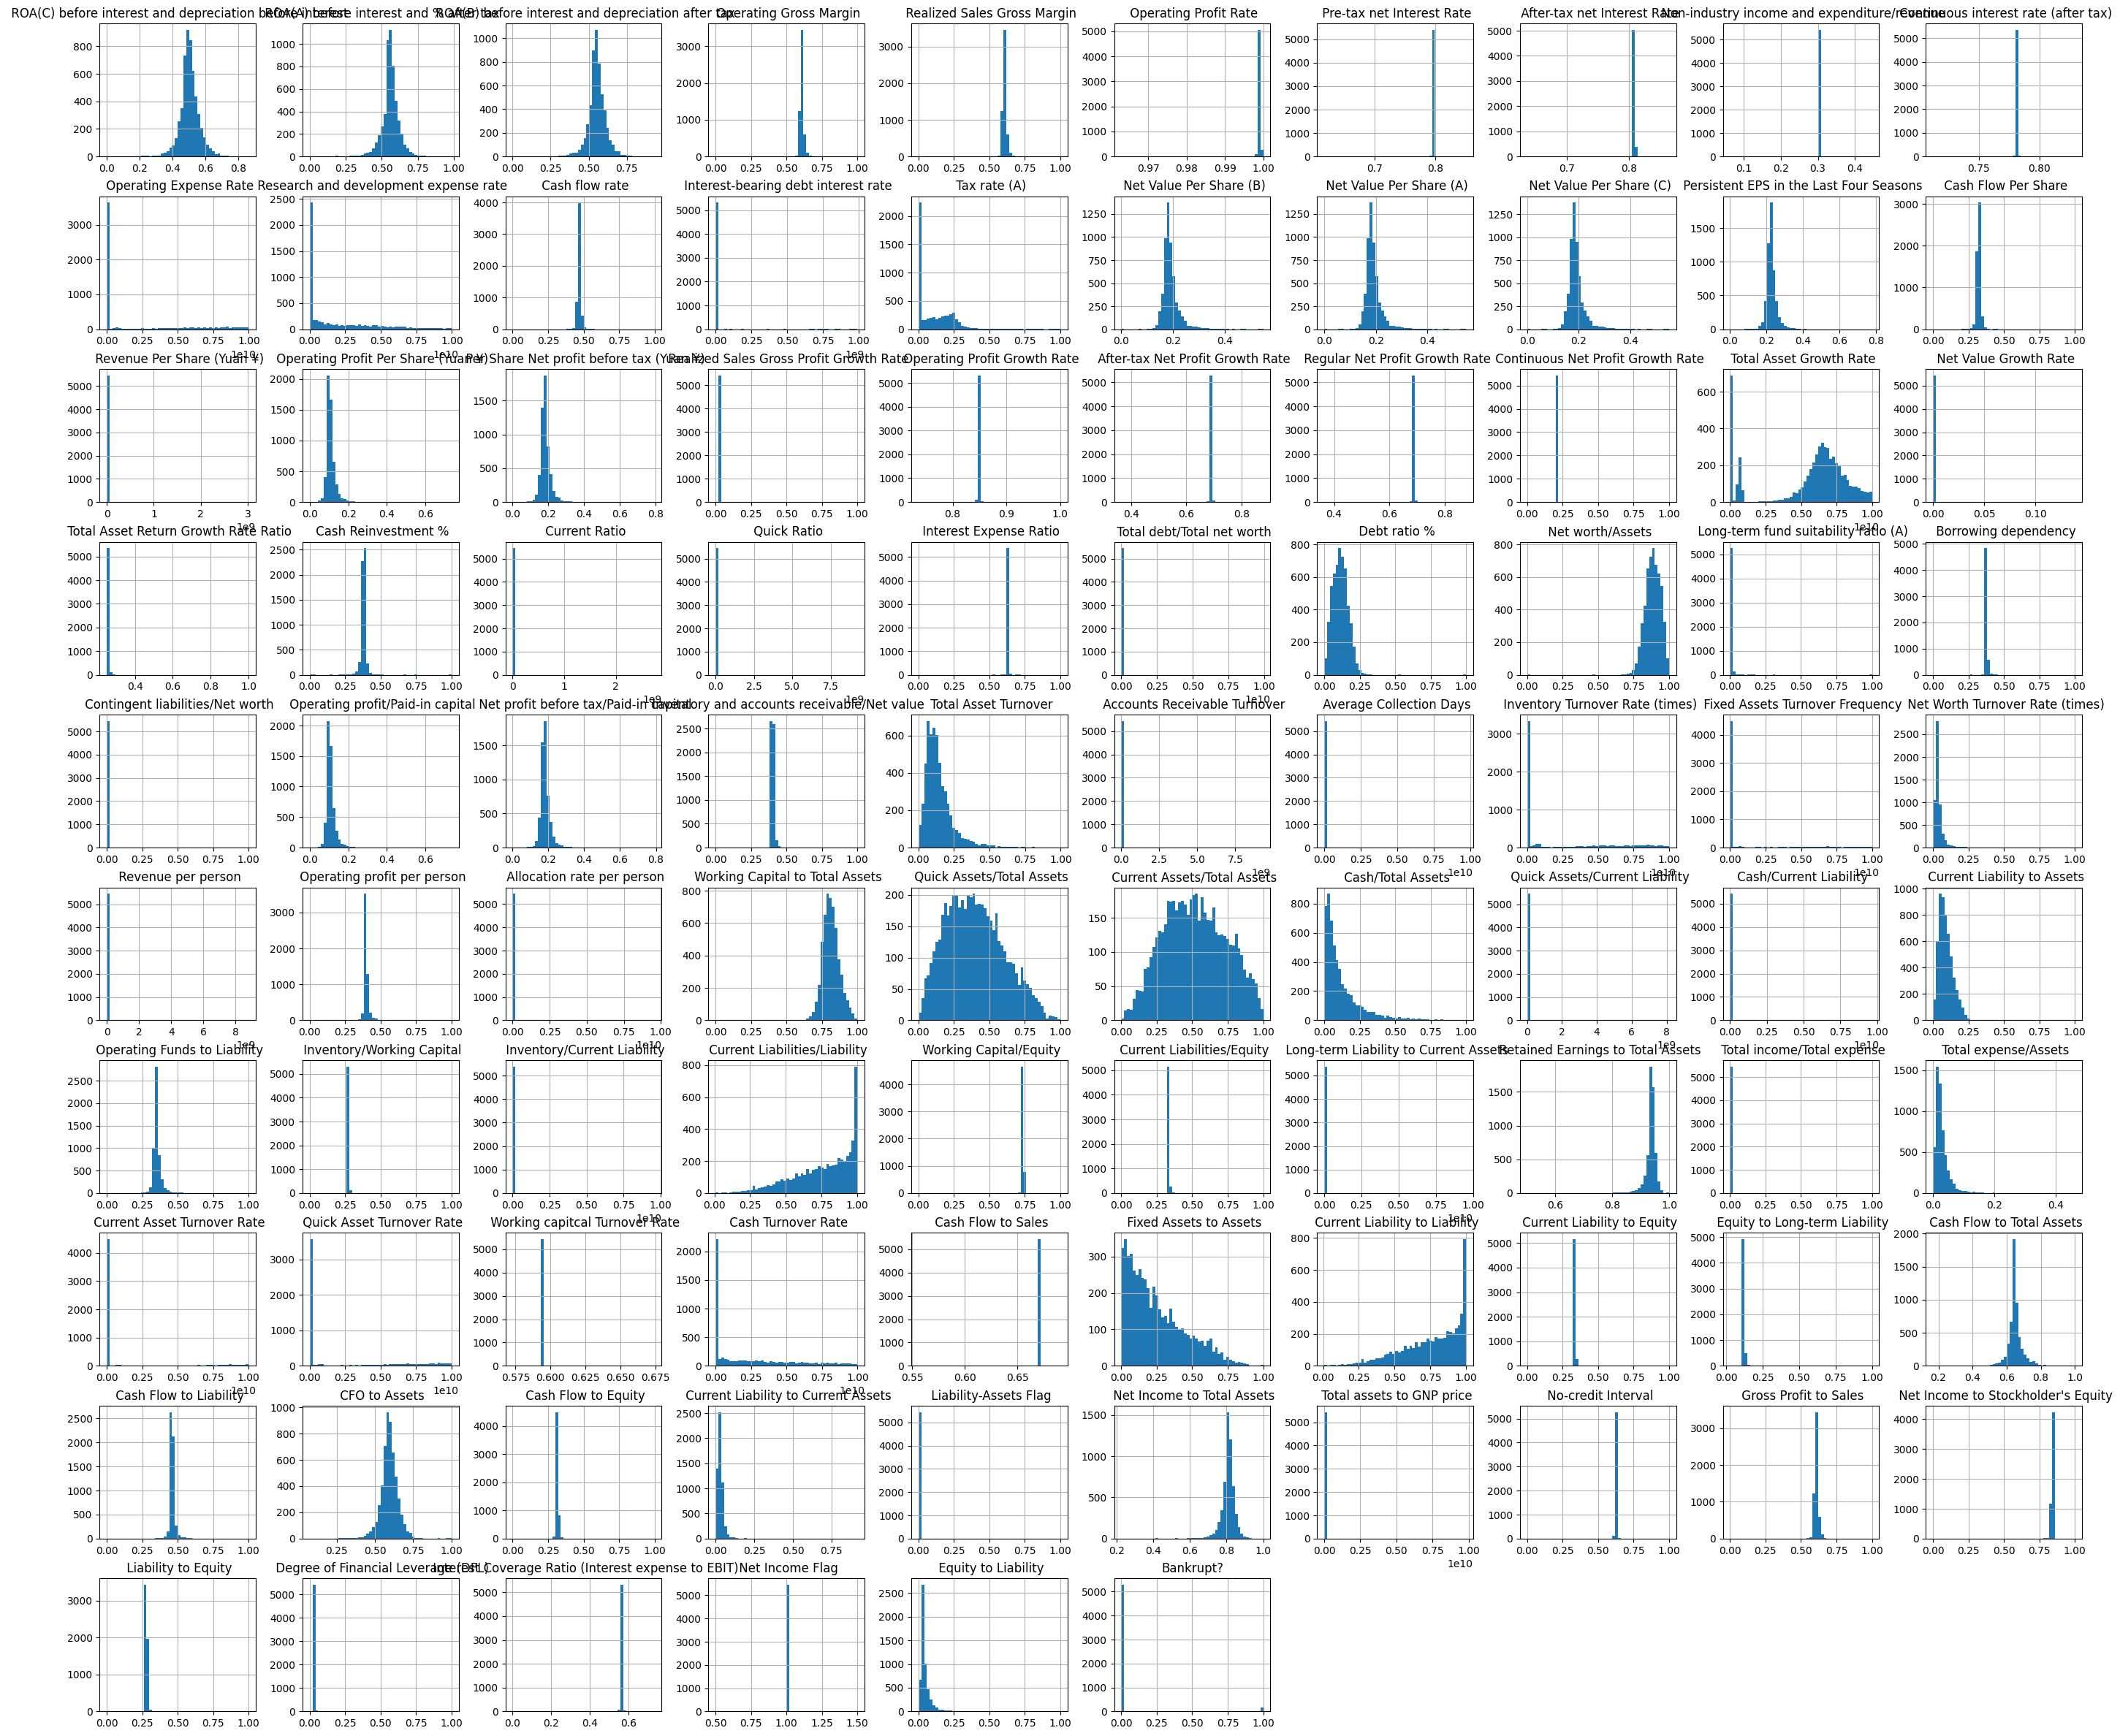

In [ ]:
feature = df.drop(columns = ['Unnamed: 0'], axis = 1)
feature.hist(figsize = (35,30), bins = 50)
plt.show()

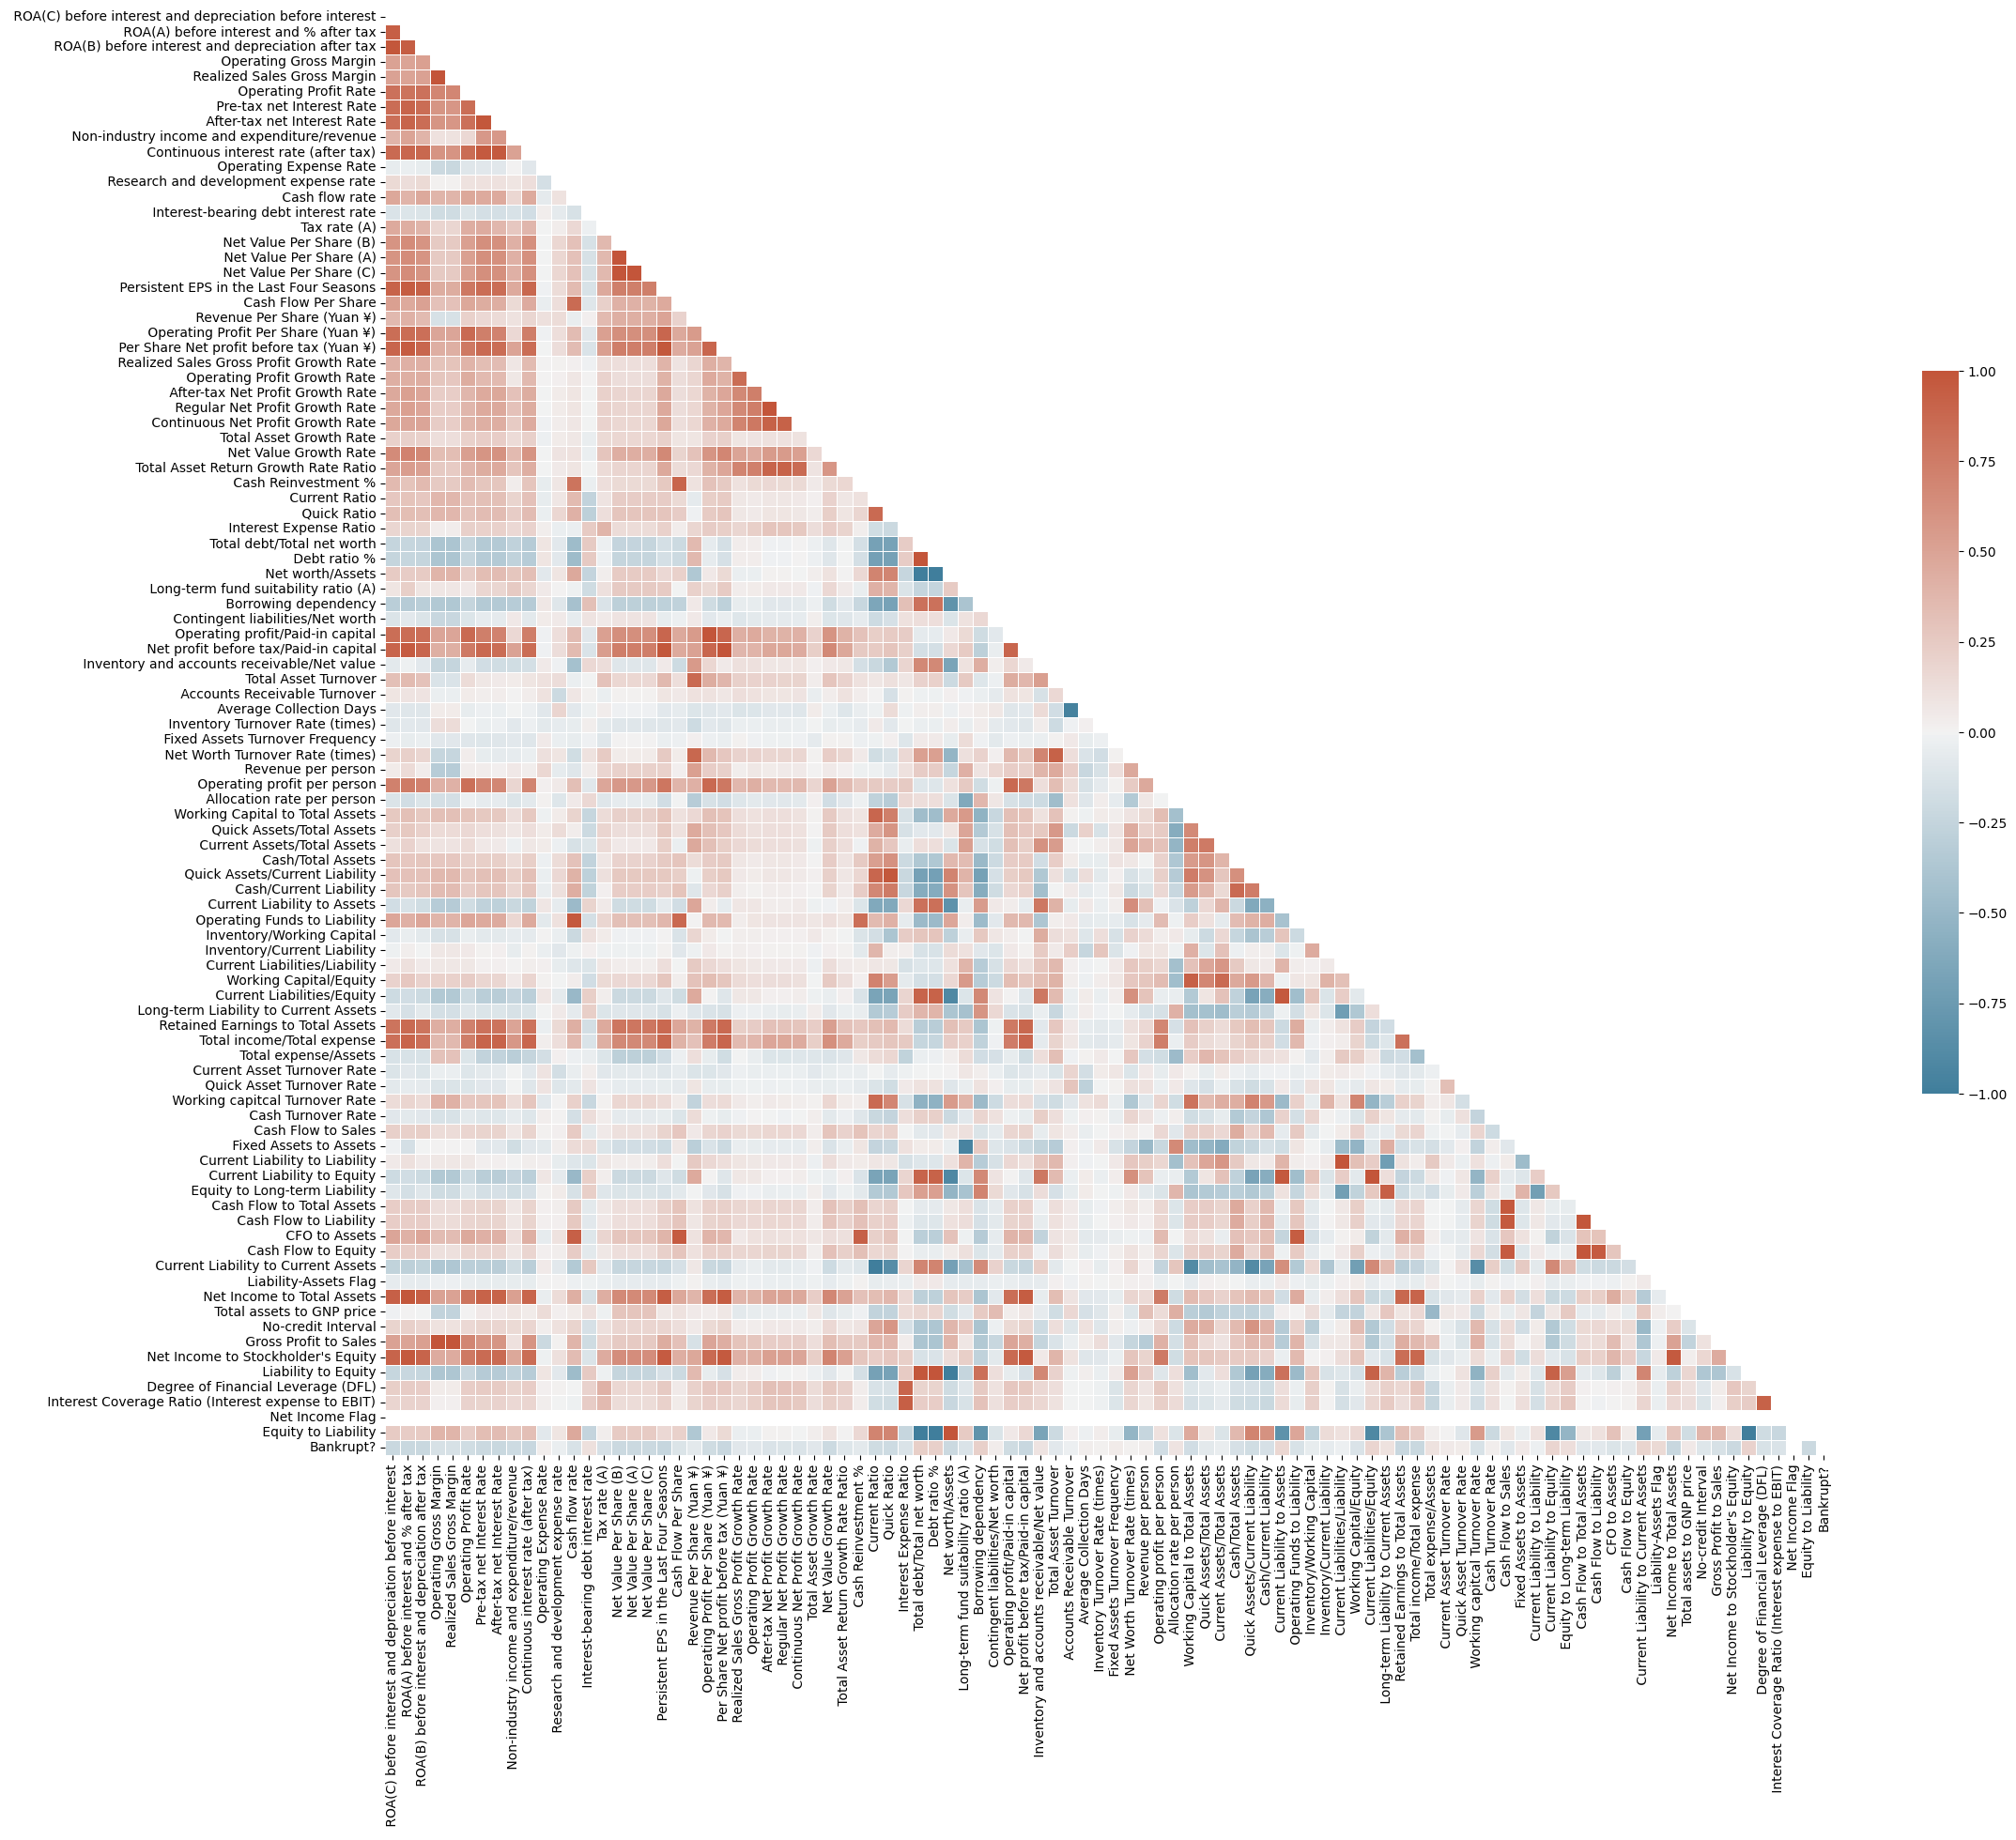

In [ ]:
# Correlation Heatmap (Spearman)

f, ax = plt.subplots(figsize=(25, 20))
mat = feature.corr('spearman')
mask = np.triu(np.ones_like(mat, dtype=bool))
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(mat, mask=mask, cmap=cmap, vmax=1, center=0,# annot = True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [ ]:
# Resample - oversample
over_sampling = RandomOverSampler(random_state= 42)
x_train_over, y_train_over = over_sampling.fit_resample(x, y)
x_train_over.shape, y_train_over.shape

((10570, 95), (10570,))

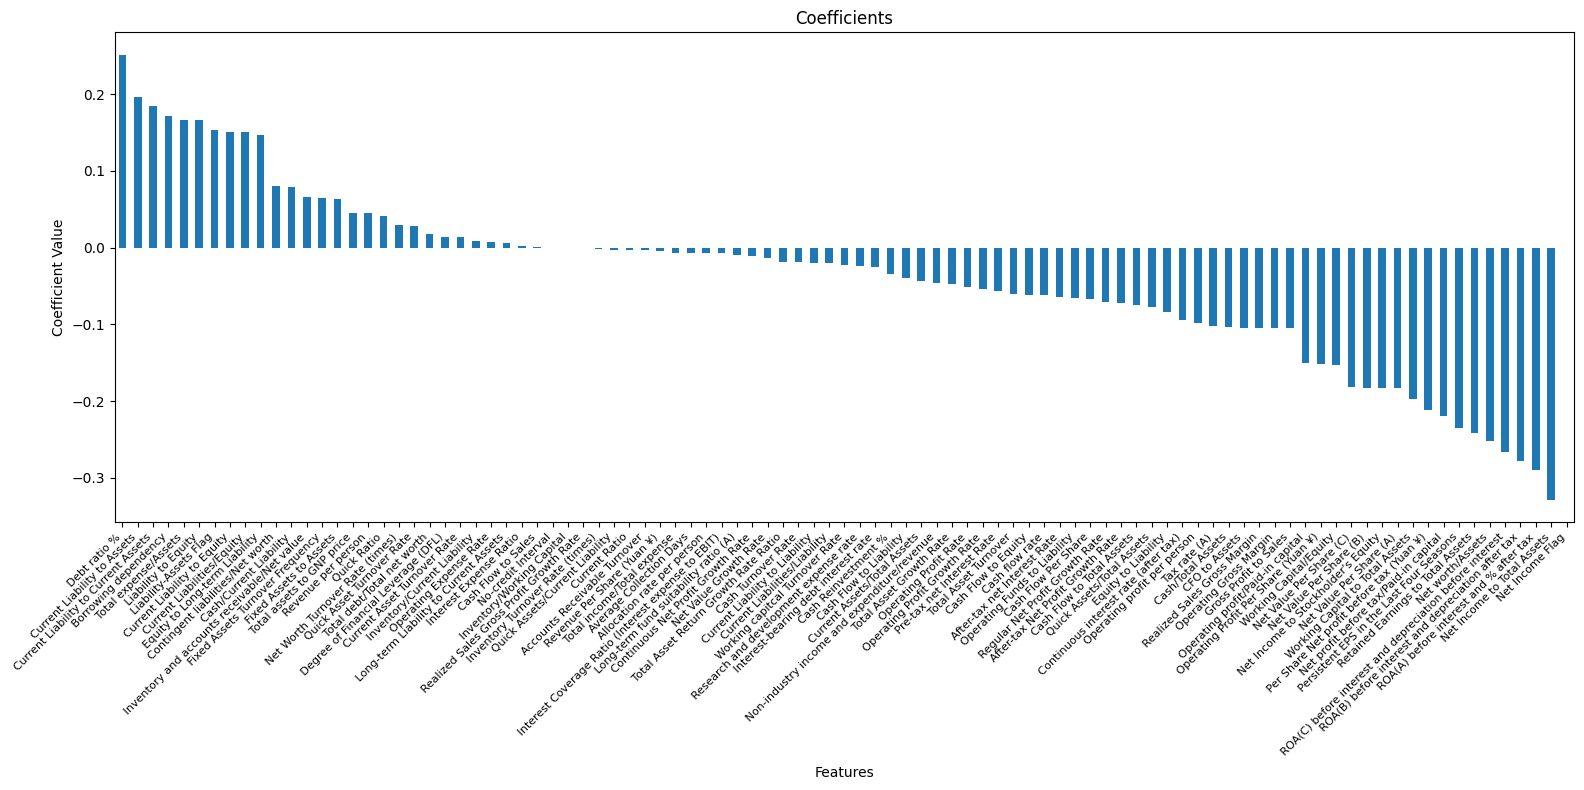

In [ ]:
# Correlation coefficient
features = [col for col in df.columns if col not in ['Unnamed: 0', 'Bankrupt?']]
feature_names = x.columns
# Calculate correlation with the binary target
corr_dict = {}
for col in features:
    corr_dict[col] = df[col].corr(df['Bankrupt?'])  # Pearson correlation

# Convert to a Pandas Series for easier sorting and plotting
corr_series = pd.Series(corr_dict)
corr_series_sorted = corr_series.sort_values(ascending = False)

# Plot as a bar chart
plt.figure(figsize=(16, 8))
corr_series_sorted.plot(kind='bar')
plt.title("Coefficients")
plt.ylabel("Coefficient Value")
plt.xlabel("Features")
plt.xticks(fontsize=8, rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Logistic Regression method prediction
model_lr = Pipeline(steps = [('scaler', StandardScaler()),
                     ('lr', LogisticRegression())])
model_lr.fit(x_train_over, y_train_over)
prob_lr = model_lr.predict(x)
num_zero = np.count_nonzero(prob_lr == 1)
lr_pred_acc = num_zero / len(prob_lr)
print("LR prediction: ",lr_pred_acc)

LR prediction:  0.13785517873510542


In [ ]:
param_grid = {
    'lr__C': [0.01, 0.1, 1, 10],  # Regularization strength
    'lr__penalty': ['l1', 'l2'],  # Type of regularization
    'lr__solver': ['liblinear', 'saga']  # Optimization algorithm
}

grid_search = GridSearchCV(model_lr, param_grid, n_jobs = -1, cv = 5)
grid_search.fit(x_train_over, y_train_over)
best_params = grid_search.best_params_
print("Best Parameters:", best_params)
lr_best_score = grid_search.best_score_
lr_best_model = grid_search.best_estimator_
lr_best_score, lr_best_model

Best Parameters: {'lr__C': 1, 'lr__penalty': 'l1', 'lr__solver': 'liblinear'}


(np.float64(0.9018921475875118),
 Pipeline(steps=[('scaler', StandardScaler()),
                 ('lr',
                  LogisticRegression(C=1, penalty='l1', solver='liblinear'))]))

In [ ]:
# Refit the lr model
lr_best_model.fit(x_train_over, y_train_over)
lr_y_prob_cv = cross_val_predict(lr_best_model, x, y, cv=5, method='predict_proba')[:, 1]

#Optimal threshold
best_threshold = 0
best_f1 = 0
for t in np.linspace(0,1, 100):
  y_pred_t = (lr_y_prob_cv >= t).astype(int)
  f1_t = f1_score(y, y_pred_t)
  if f1_t > best_f1:
    best_f1 = f1_t
    best_threshold = t
threshold = best_threshold
print("Best threshold:", np.round(threshold, 3))

# Convert probabilities to class predictions
lr_y_pred_thre = (lr_y_prob_cv >= threshold).astype(int)

lr_class_report = classification_report(y, lr_y_pred_thre)
lr_confusion_matrix = confusion_matrix(y, lr_y_pred_thre)
lr_f1 = f1_score(y, lr_y_pred_thre)
lr_auc = roc_auc_score(y, lr_y_prob_cv)
lr_accuracy = accuracy_score(y, lr_y_pred_thre)

print("F1 Score:", lr_f1)
print("ROC AUC Score:", lr_auc)
print("Accuracy:", lr_accuracy)
print("\nLr Class report:")
print(lr_class_report)
print("\nLr Confusion matrix: ")
print(lr_confusion_matrix)


Best threshold: 0.202
F1 Score: 0.42048517520215634
ROC AUC Score: 0.9034192219934332
Accuracy: 0.9605866177818515

Lr Class report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      5285
           1       0.39      0.46      0.42       170

    accuracy                           0.96      5455
   macro avg       0.69      0.72      0.70      5455
weighted avg       0.96      0.96      0.96      5455


Lr Confusion matrix: 
[[5162  123]
 [  92   78]]


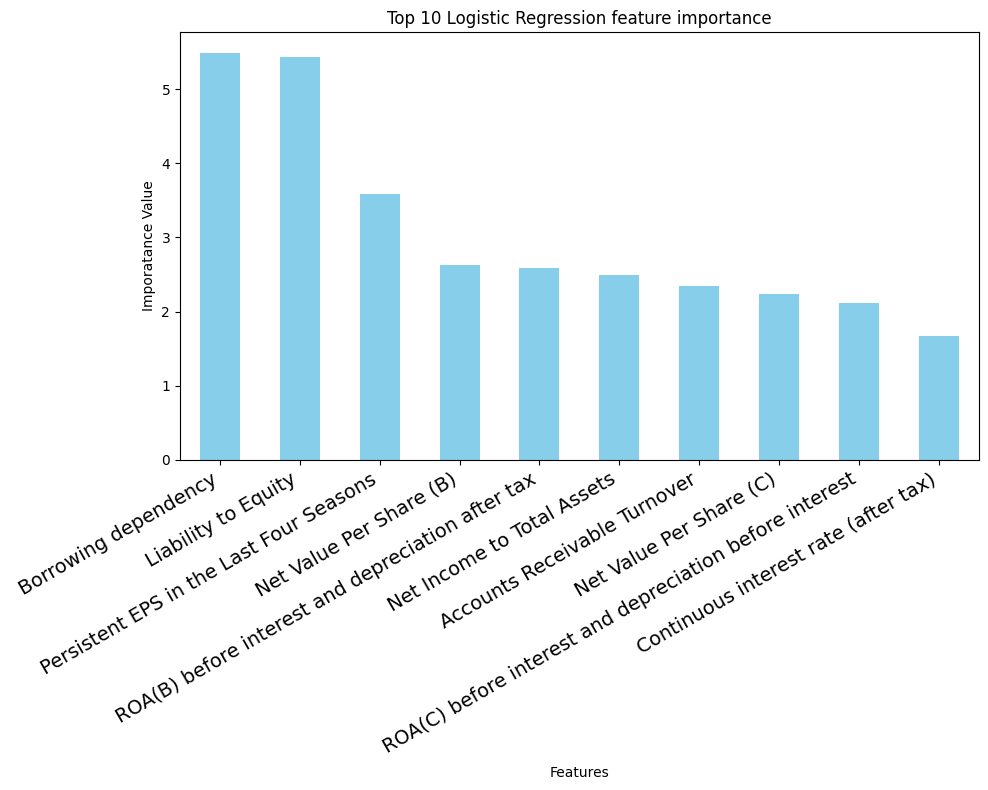

In [ ]:
# LR importance features
logreg = lr_best_model.named_steps['lr']      # the logistic regression model
scaler = lr_best_model.named_steps['scaler']  # the standard scaler (if used)

# The features you used for training (ensure the order matches the model input)
feature_names = x.columns  # or x_train.columns if that is what you fit on

# Logistic regression coefficients for each feature
coefficients = logreg.coef_[0]

# Convert to a Pandas Series and sort
imp_series = pd.Series(coefficients, index=feature_names)
imp_series_sorted = imp_series.abs().sort_values()
filtered_coef = imp_series_sorted.nlargest(10)
# Plot as a bar chart
plt.figure(figsize=(10, 8))
filtered_coef.plot(kind='bar', color='skyblue')
plt.title("Top 10 Logistic Regression feature importance")
plt.ylabel("Imporatance Value")
plt.xlabel("Features")
plt.xticks(fontsize=14, rotation=30, ha='right')
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of borrowing, by Class')

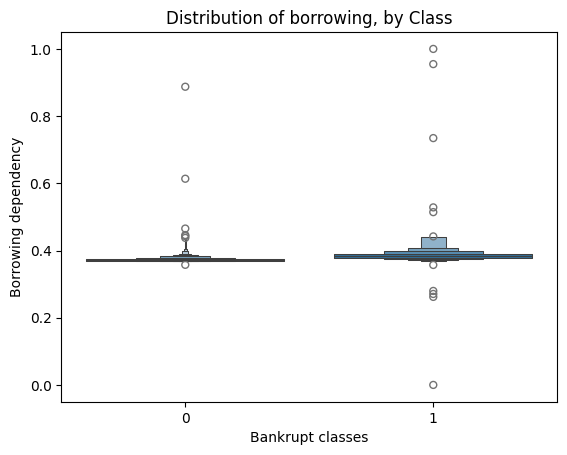

In [ ]:
sns.boxenplot(x="Bankrupt?" , y=' Borrowing dependency' , data=df)
plt.xlabel("Bankrupt classes")
plt.ylabel("Borrowing dependency")
plt.title("Distribution of borrowing, by Class")

Text(0.5, 1.0, 'Distribution of Liability/ Equity, by Class')

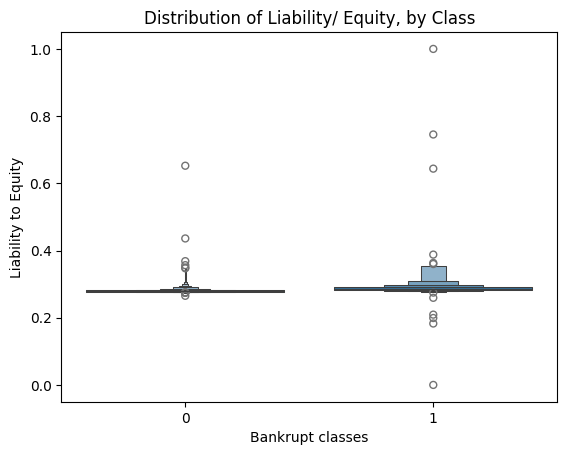

In [ ]:
sns.boxenplot(x="Bankrupt?" , y=' Liability to Equity' , data=df)
plt.xlabel("Bankrupt classes")
plt.ylabel("Liability to Equity")
plt.title("Distribution of Liability/ Equity, by Class")

In [ ]:
# Random forest method
model_rf = Pipeline([('scale', StandardScaler()),
                     ('rf', RandomForestClassifier() )])
model_rf.fit(x_train_over, y_train_over)
rf_val_pred = model_rf.predict(x)
num_one = np.count_nonzero(rf_val_pred == 1)
rf_val_pred_acc = num_one / len(rf_val_pred)
print("RF Validation predicted bankrupt rate : ",rf_val_pred_acc)

RF Validation predicted bankrupt rate :  0.031164069660861594


In [ ]:
rf_param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [1, 3, 5, 10],
    'rf__min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(model_rf, rf_param_grid, n_jobs = -1, cv=5)
grid_search_rf.fit(x_train_over, y_train_over)
rf_best_params = grid_search_rf.best_params_
print("Best Parameters:", rf_best_params)
rf_best_score = grid_search_rf.best_score_
rf_best_model = grid_search_rf.best_estimator_
rf_best_score, rf_best_model

Best Parameters: {'rf__max_depth': 10, 'rf__min_samples_split': 5, 'rf__n_estimators': 100}


(np.float64(0.9801324503311258),
 Pipeline(steps=[('scale', StandardScaler()),
                 ('rf',
                  RandomForestClassifier(max_depth=10, min_samples_split=5))]))

In [ ]:
# Refit rf model
rf_best_model.fit(x_train_over, y_train_over)
rf_y_prob_cv = cross_val_predict(rf_best_model, x, y, cv=5, method='predict_proba')[:, 1]

#Optimal threshold
best_threshold = 0
best_f1 = 0
for t in np.linspace(0,1, 100):
  y_pred_t = (rf_y_prob_cv >= t).astype(int)
  f1_t = f1_score(y, y_pred_t)
  if f1_t > best_f1:
    best_f1 = f1_t
    best_threshold = t
threshold = best_threshold
print("Best threshold:", threshold.round(3))

# Convert probabilities to class predictions
rf_y_pred_thre = (rf_y_prob_cv >= threshold).astype(int)

rf_class_report = classification_report(y, rf_y_pred_thre)
rf_confusion_matrix = confusion_matrix(y, rf_y_pred_thre)
rf_f1 = f1_score(y, rf_y_pred_thre)
rf_auc = roc_auc_score(y, rf_y_prob_cv)
rf_accuracy = accuracy_score(y, rf_y_pred_thre)

print("F1_score:", rf_f1)
print("ROC AUC Score::", rf_auc)
print("Accuracy: ", rf_accuracy)
print("\nRf Class report:")
print(rf_class_report)
print("\nRf Confusion matrix: ")
print(rf_confusion_matrix)

Best threshold: 0.192
F1_score: 0.46017699115044247
ROC AUC Score:: 0.9368095052590573
Accuracy:  0.9552703941338222

Rf Class report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5285
           1       0.37      0.61      0.46       170

    accuracy                           0.96      5455
   macro avg       0.68      0.79      0.72      5455
weighted avg       0.97      0.96      0.96      5455


Rf Confusion matrix: 
[[5107  178]
 [  66  104]]


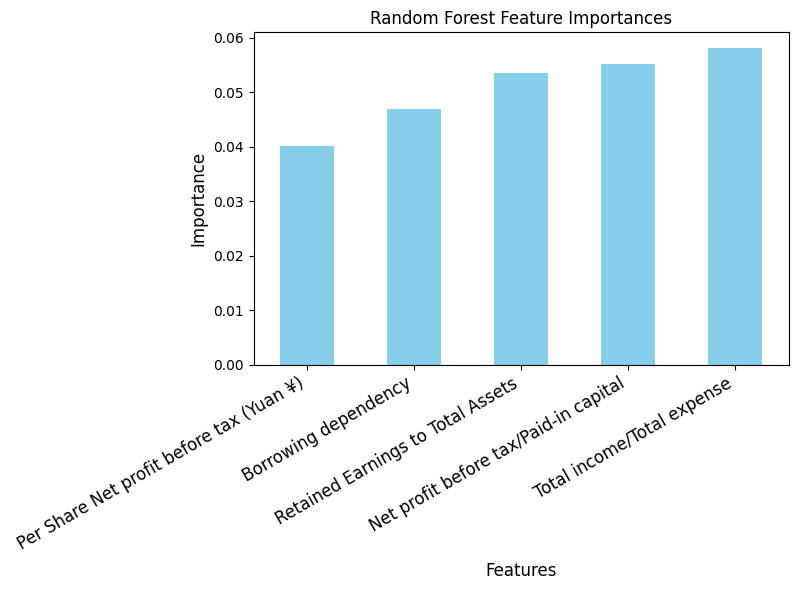

In [ ]:
# Random Forest importance features
rf = rf_best_model.named_steps['rf']  # The RandomForestClassifier

# If you scaled your data, you might also have: scaler = rf_best_model.named_steps['scale']
# But for feature importances, only the model matters.

# Get feature names (the same order used when fitting the model)
feature_names = x.columns  # or x_train.columns, depending on your code

# Retrieve the feature importances
importances = rf.feature_importances_

# Create a Pandas Series and sort by ascending order
importances_series = pd.Series(importances, index=feature_names).sort_values()
filtered_imp = importances_series[(importances_series > 0.04)]
# Plot as a bar chart
plt.figure(figsize=(8,6))
filtered_imp.plot(kind='bar', color='skyblue')
plt.title("Random Forest Feature Importances", fontsize = 12)
plt.xlabel("Features", fontsize = 12)
plt.ylabel("Importance", fontsize = 12)
plt.xticks(fontsize = 12, rotation=30, ha='right')
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Distribution of Net Income to Total Assets, by Class')

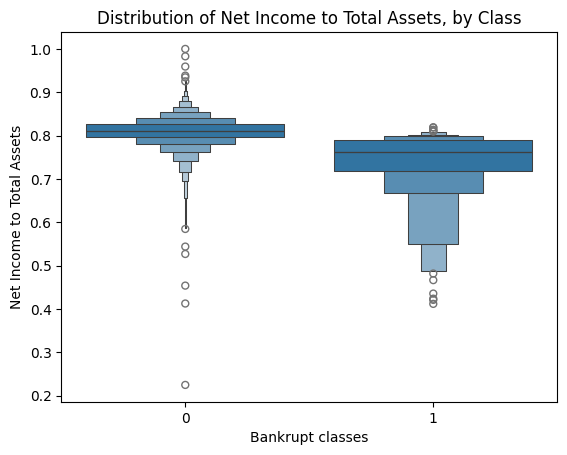

In [ ]:
sns.boxenplot(x="Bankrupt?" , y=' Net Income to Total Assets' , data=df)
plt.xlabel("Bankrupt classes")
plt.ylabel("Net Income to Total Assets")
plt.title("Distribution of Net Income to Total Assets, by Class")

In [ ]:
# Gradient boosting
model_xgb = Pipeline([('scale', StandardScaler()),
                      ('xgb', XGBClassifier())])
model_xgb.fit(x_train_over, y_train_over)
xgb_val_pred = model_xgb.predict(x)
num_zero = np.count_nonzero(xgb_val_pred == 1)
xgb_val_pred_acc = num_zero / len(xgb_val_pred)
print("XGB validation set preduction accuracy: ", xgb_val_pred_acc)

XGB validation set preduction accuracy:  0.031164069660861594


In [ ]:
grid_params = {
    'xgb__n_estimators': [50, 100, 200],
    'xgb__learning_rate': [0.001, 0.005, 0.01],
    'xgb__max_depth': [1, 2, 3]
}
grid_search_xgb = GridSearchCV(model_xgb, grid_params, n_jobs = -1, cv= 5)
grid_search_xgb.fit(x_train_over, y_train_over)

xgb_best_params = grid_search_xgb.best_params_
print("Best Parameters:", xgb_best_params)

xgb_best_score = grid_search_xgb.best_score_
xgb_best_model = grid_search_xgb.best_estimator_
xgb_best_score, xgb_best_model

Best Parameters: {'xgb__learning_rate': 0.01, 'xgb__max_depth': 3, 'xgb__n_estimators': 200}


(np.float64(0.925449385052034),
 Pipeline(steps=[('scale', StandardScaler()),
                 ('xgb',
                  XGBClassifier(base_score=None, booster=None, callbacks=None,
                                colsample_bylevel=None, colsample_bynode=None,
                                colsample_bytree=None, device=None,
                                early_stopping_rounds=None,
                                enable_categorical=False, eval_metric=None,
                                feature_types=None, gamma=None, grow_policy=None,
                                importance_type=None,
                                interaction_constraints=None, learning_rate=0.01,
                                max_bin=None, max_cat_threshold=None,
                                max_cat_to_onehot=None, max_delta_step=None,
                                max_depth=3, max_leaves=None,
                                min_child_weight=None, missing=nan,
                                monotone

In [ ]:
#Refit XGB model
xgb_best_model.fit(x_train_over, y_train_over)
xgb_y_prob_cv = cross_val_predict(xgb_best_model, x, y, cv=5, method = 'predict_proba')[:, 1]

# Find the optimal threshold
best_threshold = 0
best_f1 = 0
for t in np.linspace(0,1, 100):
  y_pred_t = (xgb_y_prob_cv >= t).astype(int)
  f1_t = f1_score(y, y_pred_t)
  if f1_t > best_f1:
    best_f1 = f1_t
    best_threshold = t
threshold = best_threshold
print("Best threshold:", threshold.round(3))

# Convert probabilities to class predictions
xgb_y_pred_thre = (xgb_y_prob_cv >= threshold)

xgb_class_report = classification_report(y, xgb_y_pred_thre)
xgb_confusion_matrix = confusion_matrix(y, xgb_y_pred_thre)
xgb_f1 = f1_score(y, xgb_y_pred_thre)
xgb_auc = roc_auc_score(y, xgb_y_prob_cv)
xgb_acc = accuracy_score(y, xgb_y_pred_thre)

print("xgb F1 score:", xgb_f1)
print("xgb ROC AUC core:", xgb_auc)
print("xgb Accuracy: ",xgb_acc)
print("\nXGB Class report:")
print(xgb_class_report)
print("\nXGB Confusion matrix: ")
print(xgb_confusion_matrix)

Best threshold: 0.172
xgb F1 score: 0.46788990825688076
xgb ROC AUC core: 0.9324186098280371
xgb Accuracy:  0.9574702108157653

XGB Class report:
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      5285
           1       0.38      0.60      0.47       170

    accuracy                           0.96      5455
   macro avg       0.69      0.78      0.72      5455
weighted avg       0.97      0.96      0.96      5455


XGB Confusion matrix: 
[[5121  164]
 [  68  102]]


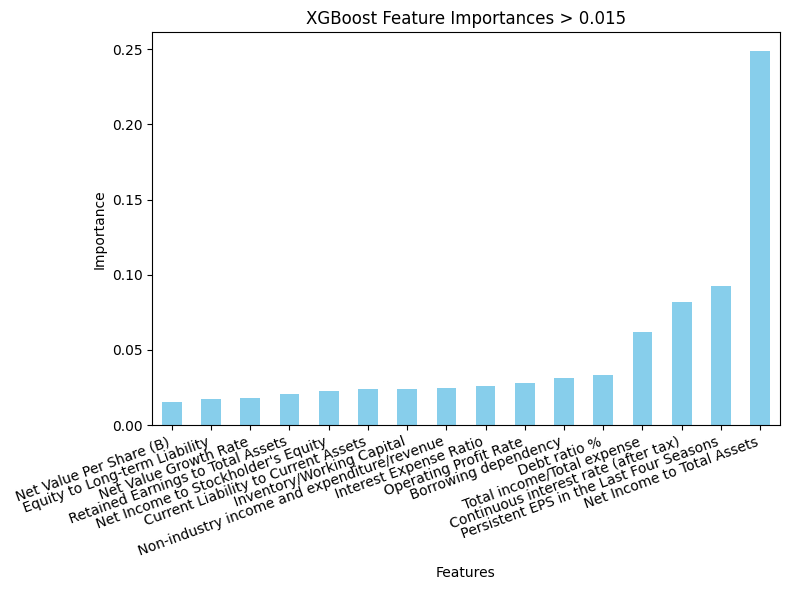

In [ ]:
#XGBoost importance feature
xgb_clf = xgb_best_model.named_steps['xgb']  # The XGBClassifier

# If you scaled your data, you might also have: scaler = xgb_best_model.named_steps['scale']

# Get feature names
feature_names = x.columns

# Retrieve feature importances
xgb_importances = xgb_clf.feature_importances_

# Create a Pandas Series and sort by ascending order
xgb_importances_series = pd.Series(xgb_importances, index=feature_names).sort_values()
filtered_imp = xgb_importances_series[xgb_importances_series > 0.015]
# Plot as a bar chart
plt.figure(figsize=(8,6))
filtered_imp.plot(kind='bar', color='skyblue')
plt.title("XGBoost Feature Importances > 0.015")
plt.xlabel("Features")
plt.ylabel("Importance")
plt.xticks(rotation=20, ha='right')
plt.tight_layout()
plt.show()


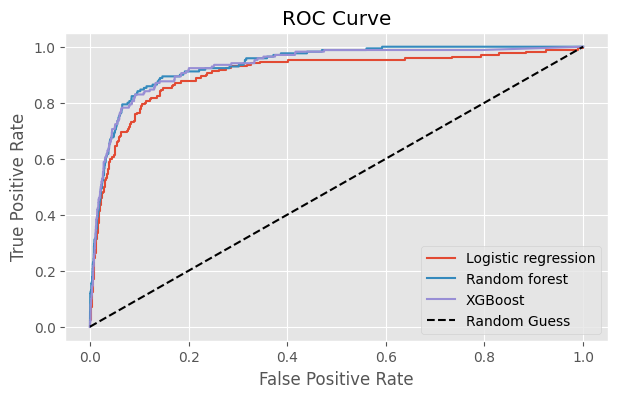

In [ ]:
# ROC curve
fpr_lr, tpr_lr, _ = roc_curve(y, lr_y_prob_cv)
fpr_rf, tpr_rf, _ = roc_curve(y, rf_y_prob_cv)
fpr_xgb, tpr_xgb, _ = roc_curve(y, xgb_y_prob_cv)
with plt.style.context('ggplot'):
    plt.figure(figsize=(7,4))
    plt.plot(fpr_lr, tpr_lr, label='Logistic regression') # under random forest curve
    plt.plot(fpr_rf, tpr_rf, label='Random forest')
    plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
    plt.plot([0, 1], [0, 1], color='black', linestyle='--', label='Random Guess')

    plt.title('ROC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc='lower right')
    plt.grid(True)

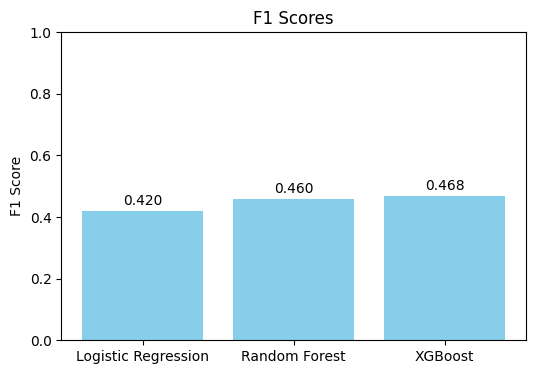

In [ ]:
# Comparing models by data visaulization
# f1 score
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
f1_scores = [lr_f1, rf_f1, xgb_f1]
plt.figure(figsize=(6,4))
bars = plt.bar(models, f1_scores, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: center of the bar
        height + 0.01,                     # Y-coordinate: slightly above the bar
        f"{height:.3f}",                   # Format to 2 decimal places
        ha='center', va='bottom'
    )


plt.ylim(0, 1)
plt.title("F1 Scores")
plt.ylabel("F1 Score")
plt.show()


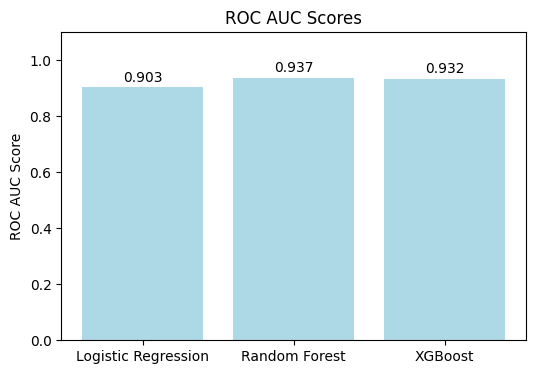

In [ ]:
# ROC AUC score
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
auc_scores = [lr_auc, rf_auc, xgb_auc]

plt.figure(figsize=(6,4))
bars = plt.bar(models, auc_scores, color='lightblue')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: center of the bar
        height + 0.01,                     # Y-coordinate: slightly above the bar
        f"{height:.3f}",                   # Format to 2 decimal places
        ha='center', va='bottom'
    )

plt.ylim(0, 1.1)
plt.title("ROC AUC Scores")
plt.ylabel("ROC AUC Score")
plt.show()

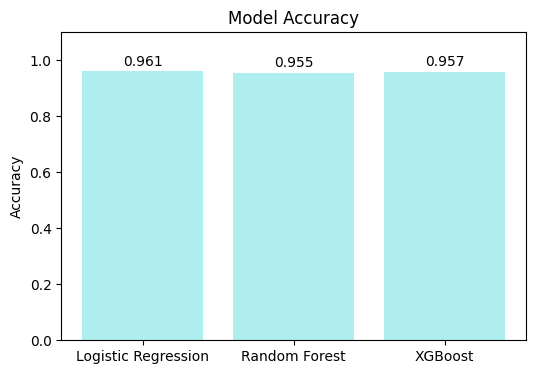

In [ ]:
# Accuracy rate
models = ['Logistic Regression', 'Random Forest', 'XGBoost']
accuracy_scores = [lr_accuracy, rf_accuracy, xgb_acc]

plt.figure(figsize=(6,4))
bars = plt.bar(models, accuracy_scores, color='paleturquoise')

for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,  # X-coordinate: center of the bar
        height + 0.01,                     # Y-coordinate: slightly above the bar
        f"{height:.3f}",                   # Format to 2 decimal places
        ha='center', va='bottom'
    )

plt.ylim(0, 1.1)  # If your accuracy is between 0.0 and 1.0
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.show()

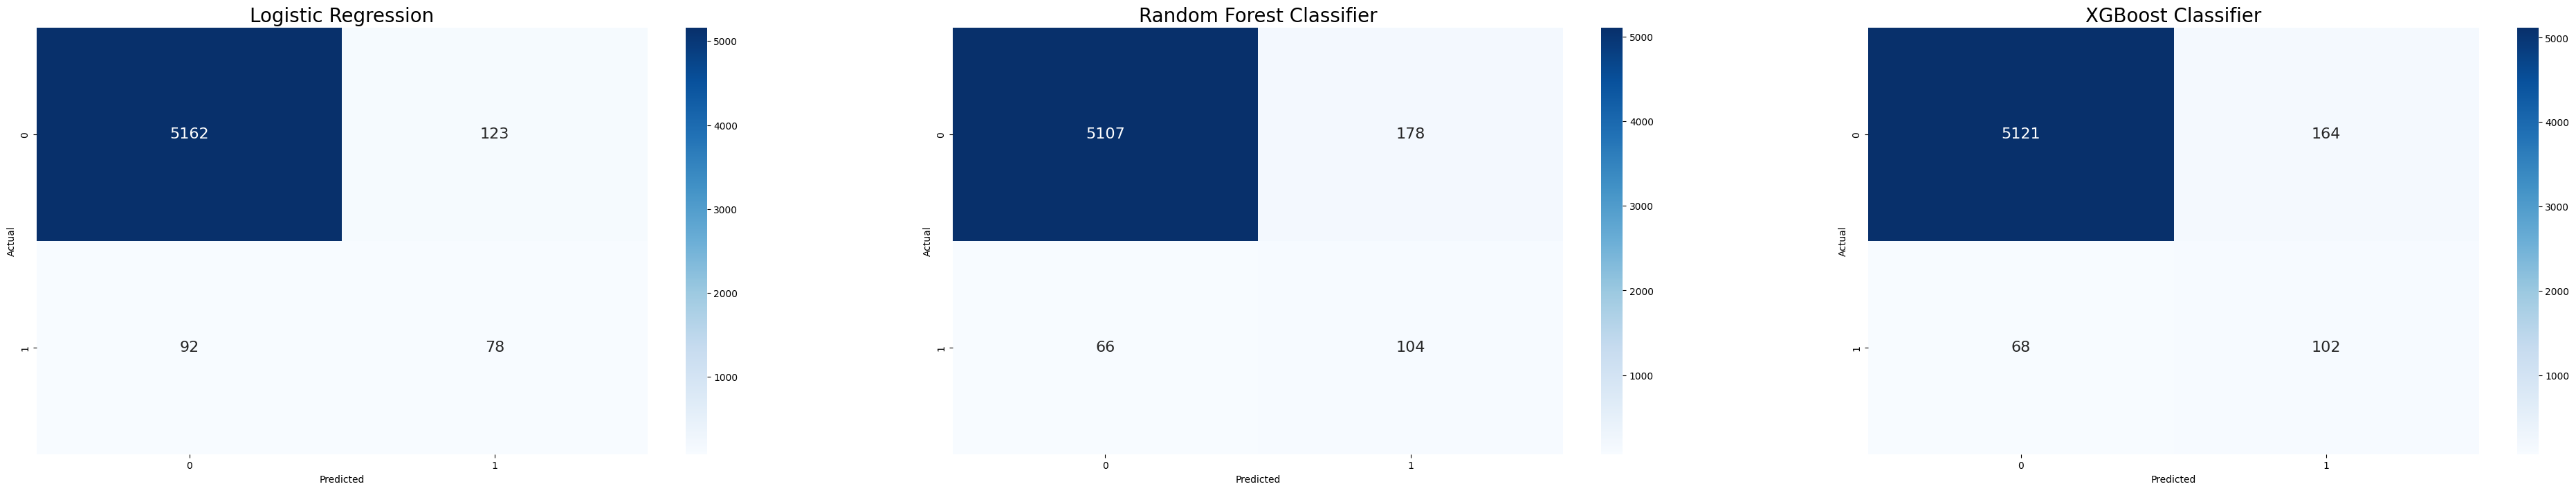

In [ ]:
# Confusion matrics
heat_lr = pd.DataFrame(lr_confusion_matrix, columns=np.unique(y), index = np.unique(y))
heat_lr.index.name = 'Actual'
heat_lr.columns.name = 'Predicted'

heat_rf = pd.DataFrame(rf_confusion_matrix, columns=np.unique(y), index = np.unique(y))
heat_rf.index.name = 'Actual'
heat_rf.columns.name = 'Predicted'

heat_xgb = pd.DataFrame(xgb_confusion_matrix, columns=np.unique(y), index = np.unique(y))
heat_xgb.index.name = 'Actual'
heat_xgb.columns.name = 'Predicted'

f, ax = plt.subplots(1, 3, figsize=(20,8))
f.subplots_adjust(left=None, bottom=None, right= 2, top=None, wspace=None, hspace= None)

sns.heatmap(heat_lr, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[0])
ax[0].set_title('Logistic Regression', fontsize = 20)
sns.heatmap(heat_rf, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[1])
ax[1].set_title('Random Forest Classifier', fontsize = 20)
sns.heatmap(heat_xgb, cmap="Blues", annot=True, annot_kws={"size": 16},fmt='g', ax = ax[2])
ax[2].set_title('XGBoost Classifier', fontsize = 20)

plt.show()

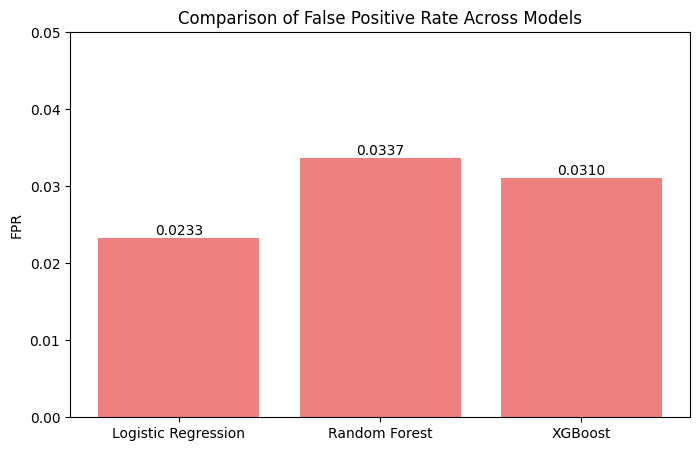

In [ ]:
# FP rate
fpr_lr = lr_confusion_matrix[0, 1] / (lr_confusion_matrix[0, 0] + lr_confusion_matrix[0, 1])
fpr_rf = rf_confusion_matrix[0, 1] / (rf_confusion_matrix[0, 0] + rf_confusion_matrix[0, 1])
fpr_xgb = xgb_confusion_matrix[0, 1] / (xgb_confusion_matrix[0, 0] + xgb_confusion_matrix[0, 1])

models = ['Logistic Regression', 'Random Forest', 'XGBoost']
fpr = [fpr_lr, fpr_rf, fpr_xgb]

plt.figure(figsize=(8,5))
bars = plt.bar(models, fpr, color='lightcoral')
plt.ylim(0, 0.05)
plt.title("Comparison of False Positive Rate Across Models")
plt.ylabel("FPR")

# Add numeric labels above each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}", ha='center', va='bottom')

plt.show()

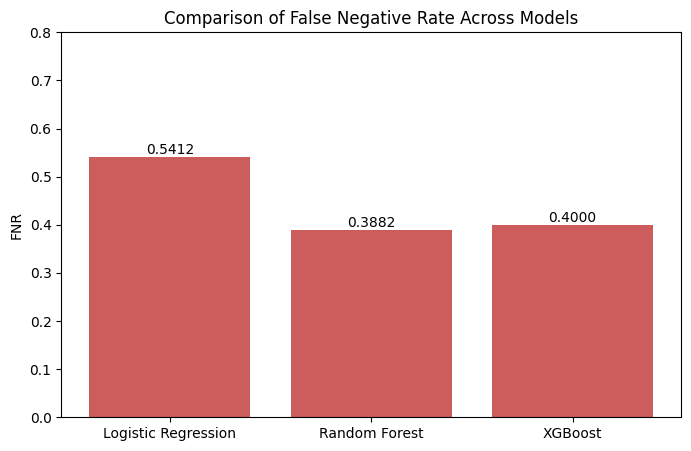

In [ ]:
# FN rate
fnr_lr = lr_confusion_matrix[1, 0] / (lr_confusion_matrix[1, 0] + lr_confusion_matrix[1, 1])
fnr_rf = rf_confusion_matrix[1, 0] / (rf_confusion_matrix[1, 0] + rf_confusion_matrix[1, 1])
fnr_xgb = xgb_confusion_matrix[1, 0] / (xgb_confusion_matrix[1, 0] + xgb_confusion_matrix[1, 1])

models = ['Logistic Regression', 'Random Forest', 'XGBoost']
fnr = [fnr_lr, fnr_rf, fnr_xgb]

plt.figure(figsize=(8,5))
bars = plt.bar(models, fnr, color='indianred')
plt.ylim(0, 0.8)
plt.title("Comparison of False Negative Rate Across Models")
plt.ylabel("FNR")

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f"{height:.4f}", ha='center', va='bottom')

plt.show()

In [ ]:
# Models testing
df_test = pd.read_csv('/content/test (2).csv')
df_test.shape

(1364, 96)

In [ ]:
df_test.columns

Index(['Unnamed: 0',
       ' ROA(C) before interest and depreciation before interest',
       ' ROA(A) before interest and % after tax',
       ' ROA(B) before interest and depreciation after tax',
       ' Operating Gross Margin', ' Realized Sales Gross Margin',
       ' Operating Profit Rate', ' Pre-tax net Interest Rate',
       ' After-tax net Interest Rate',
       ' Non-industry income and expenditure/revenue',
       ' Continuous interest rate (after tax)', ' Operating Expense Rate',
       ' Research and development expense rate', ' Cash flow rate',
       ' Interest-bearing debt interest rate', ' Tax rate (A)',
       ' Net Value Per Share (B)', ' Net Value Per Share (A)',
       ' Net Value Per Share (C)', ' Persistent EPS in the Last Four Seasons',
       ' Cash Flow Per Share', ' Revenue Per Share (Yuan ¥)',
       ' Operating Profit Per Share (Yuan ¥)',
       ' Per Share Net profit before tax (Yuan ¥)',
       ' Realized Sales Gross Profit Growth Rate',
       ' Operatin

In [ ]:
df_test.head()

,Unnamed: 0,ROA(C) before interest and depreciation before interest,ROA(A) before interest and % after tax,ROA(B) before interest and depreciation after tax,Operating Gross Margin,Realized Sales Gross Margin,Operating Profit Rate,Pre-tax net Interest Rate,After-tax net Interest Rate,Non-industry income and expenditure/revenue,...,Net Income to Total Assets,Total assets to GNP price,No-credit Interval,Gross Profit to Sales,Net Income to Stockholder's Equity,Liability to Equity,Degree of Financial Leverage (DFL),Interest Coverage Ratio (Interest expense to EBIT),Net Income Flag,Equity to Liability
0,313,0.477843,0.543066,0.530971,0.601551,0.601385,0.998982,0.797425,0.809347,0.303560,...,0.802411,0.002498,0.624508,0.601549,0.840452,0.277248,0.026933,0.565754,1,0.047947
1,6724,0.471750,0.537178,0.526099,0.597198,0.597198,0.998968,0.797385,0.809313,0.303517,...,0.798262,0.003474,0.623589,0.597193,0.840230,0.279860,0.028270,0.568097,1,0.028924
2,4494,0.455906,0.503216,0.513357,0.606588,0.606740,0.998894,0.797101,0.809085,0.303177,...,0.778362,0.016904,0.623824,0.606590,0.838494,0.280741,0.026606,0.564091,1,0.026206
3,5422,0.491103,0.542575,0.543445,0.602668,0.602668,0.999013,0.797431,0.809345,0.303505,...,0.801665,0.001678,0.625368,0.602668,0.840514,0.279999,0.026869,0.565504,1,0.028434
4,2754,0.506849,0.550316,0.554901,0.602538,0.602409,0.999019,0.797417,0.809328,0.303467,...,0.803628,0.001889,0.623598,0.602538,0.840614,0.278829,0.027218,0.566608,1,0.033571


In [ ]:
'Bankrupt?' in df_test.columns

False

In [ ]:
# Random Forest is the best predict model
x_test = df_test.drop(columns=['Unnamed: 0']) # Drop 'Bankrupt' column
rf_y_pred = rf_best_model.predict(x_test)
pred_non_bankruptcy = np.count_nonzero(rf_y_pred == 0) / len(rf_y_pred)
print("Non bankruptcy rate: ", pred_non_bankruptcy)

Non bankruptcy rate:  0.9398826979472141


In [ ]:
# Create a DataFrame with the predictions
# Here we assume 'Unnamed: 0' contains an ID for each sample.
predictions_df = df_test[['Unnamed: 0']].copy()
predictions_df['BankruptPrediction'] = rf_y_pred

# Save the predictions to a CSV file
predictions_df.to_csv('rf_bankruptcy_predictions.csv', index=False)
print("CSV file 'rf_bankruptcy_predictions.csv' has been created with the predictions.")

CSV file 'rf_bankruptcy_predictions.csv' has been created with the predictions.
